# Analytics

#### Date: 2021/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- Érico Maximiano Bandeira
- Henrique Martins de Messias
- João Vitor Moura Rosa
- Max Henrique Barbosa
- Victor Rodrigues Silva
- Antonio Igor Carvalho
- Gabriel Santos Silva Araújo
- João Paulo Lima da Silva
- Lucas Vieira de Jesus

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('../analytics-raw-data/*.json') # add the path here

In [5]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)
        
        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)

    aux_df = df['filename'].str.split(r"Oraculo-(.*?)-*-(.*?).json", expand=True)

    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [6]:
base_component_df = create_base_component_df(jsons)

In [7]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
9,duplicated_lines_density,0.0,True,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
10,functions,4,NaN,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
11,security_rating,1.0,True,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
12,files,11,NaN,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
13,complexity,7,NaN,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
14,ncloc,118,NaN,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
15,coverage,0.0,False,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
16,reliability_rating,1.0,True,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
17,comment_lines_density,18.1,False,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
36,duplicated_lines_density,2.7,False,fga-eps-mds-2021_1-Oraculo-FrontEnd-10-19-2021...,FrontEnd,10-19-2021-02-02


#### Create dataframe per file

In [8]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [9]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"Oraculo-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [10]:
file_component_df = create_file_df(jsons)

In [11]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
3,src/App.js,1,1,0.0,0.0,0.0,21,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
4,src/App.test.js,1,1,0.0,0.0,0.0,7,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
5,src/index.js,0,0,20.0,0.0,0.0,12,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
6,src/reportWebVitals.js,2,4,0.0,0.0,0.0,12,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
7,src/setupTests.js,0,0,0.0,0.0,NaN,1,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-Oraculo-FrontEnd-09-14-2021...,FrontEnd,09-14-2021-02-19
67,src/App.js,1,1,0.0,0.0,100.0,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-Oraculo-FrontEnd-10-19-2021...,FrontEnd,10-19-2021-02-02
68,src/App.test.js,1,1,0.0,0.0,0.0,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-Oraculo-FrontEnd-10-19-2021...,FrontEnd,10-19-2021-02-02
69,src/Auth/Auth.js,3,3,0.0,0.0,100.0,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-Oraculo-FrontEnd-10-19-2021...,FrontEnd,10-19-2021-02-02
70,src/Services/Axios/BaseService/baseService.js,6,13,0.0,0.0,13.3,62,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-Oraculo-FrontEnd-10-19-2021...,FrontEnd,10-19-2021-02-02
71,src/Constants/baseUrls.js,0,0,66.7,0.0,100.0,3,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2021_1-Oraculo-FrontEnd-10-19-2021...,FrontEnd,10-19-2021-02-02


#### Create dataframe per repository

In [12]:
# Example

frontEnd_df = file_component_df[file_component_df['repository'] == 'FrontEnd']
tags_df = file_component_df[file_component_df['repository'] == 'Tags']
profile_df = file_component_df[file_component_df['repository'] == 'Profile']
processos_df = file_component_df[file_component_df['repository'] == 'Processos']

In [13]:
def _nloc(df):
    ncloc = 0
    for each in df['ncloc']:
        ncloc += int(each)

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [14]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [15]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [16]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [17]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [18]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds if not np.isnan(density_fast_test_builds) else 0

##### Test coverage

In [19]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [20]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_nloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [21]:
frontEnd_metrics = create_metrics_df(frontEnd_df)
tags_metrics = create_metrics_df(tags_df)
profile_metrics = create_metrics_df(profile_df)
processos_metrics = create_metrics_df(processos_df)

### Data visualization

- You must do this for each of your repositories

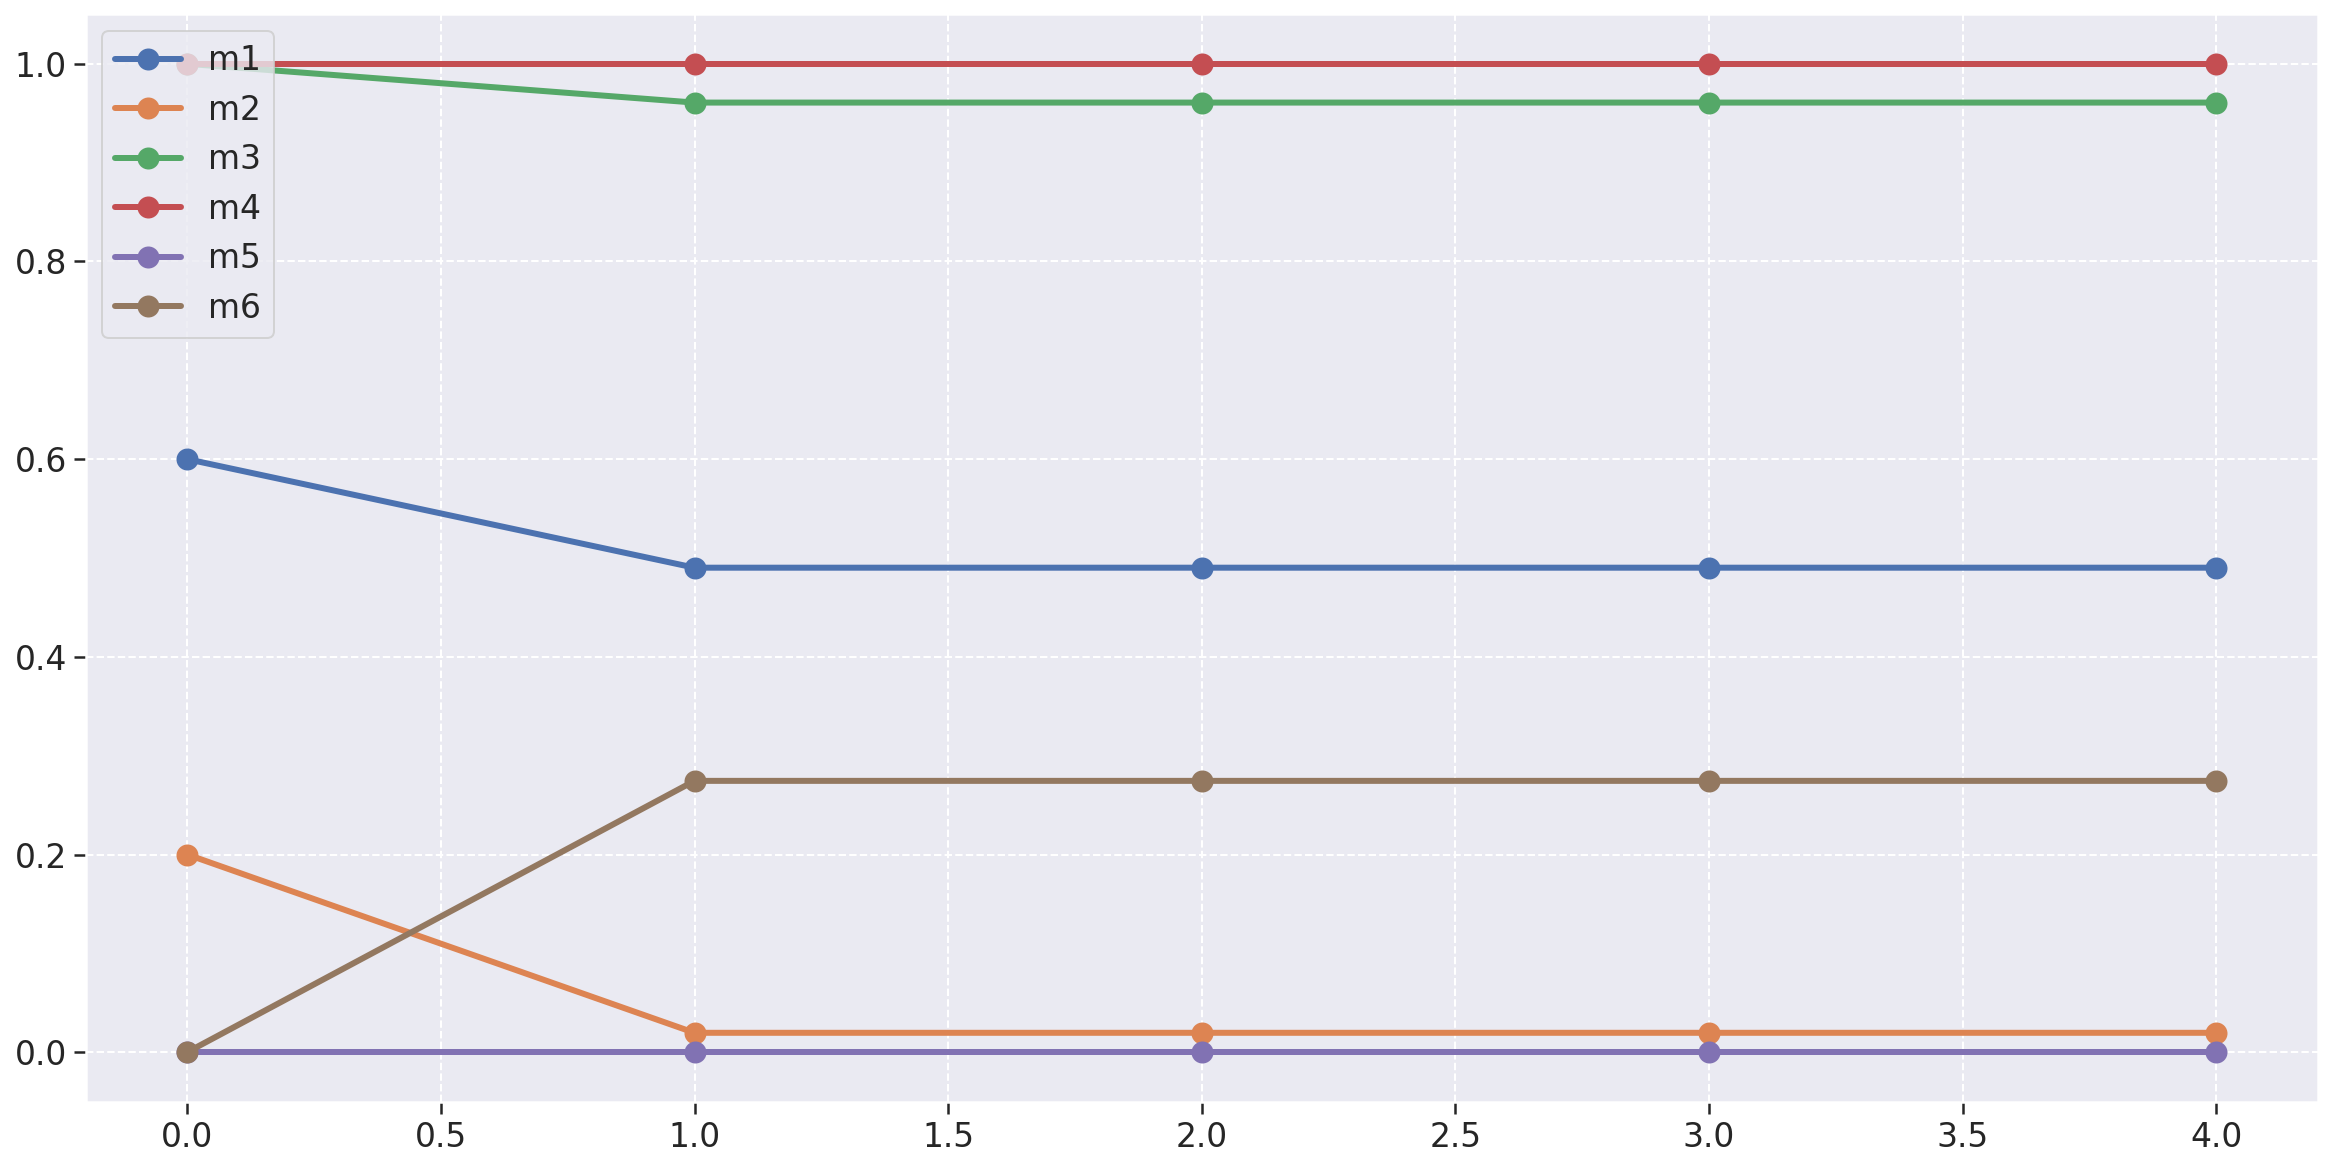

In [22]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontEnd_metrics['m1'], label='m1', linewidth=3, marker='o', markersize=10)
plt.plot(frontEnd_metrics['m2'], label='m2', linewidth=3, marker='o', markersize=10)
plt.plot(frontEnd_metrics['m3'], label='m3', linewidth=3, marker='o', markersize=10)
plt.plot(frontEnd_metrics['m4'], label='m4', linewidth=3, marker='o', markersize=10)
plt.plot(frontEnd_metrics['m5'], label='m5', linewidth=3, marker='o', markersize=10)
plt.plot(frontEnd_metrics['m6'], label='m6', linewidth=3, marker='o', markersize=10)

plt.legend(loc='upper left')

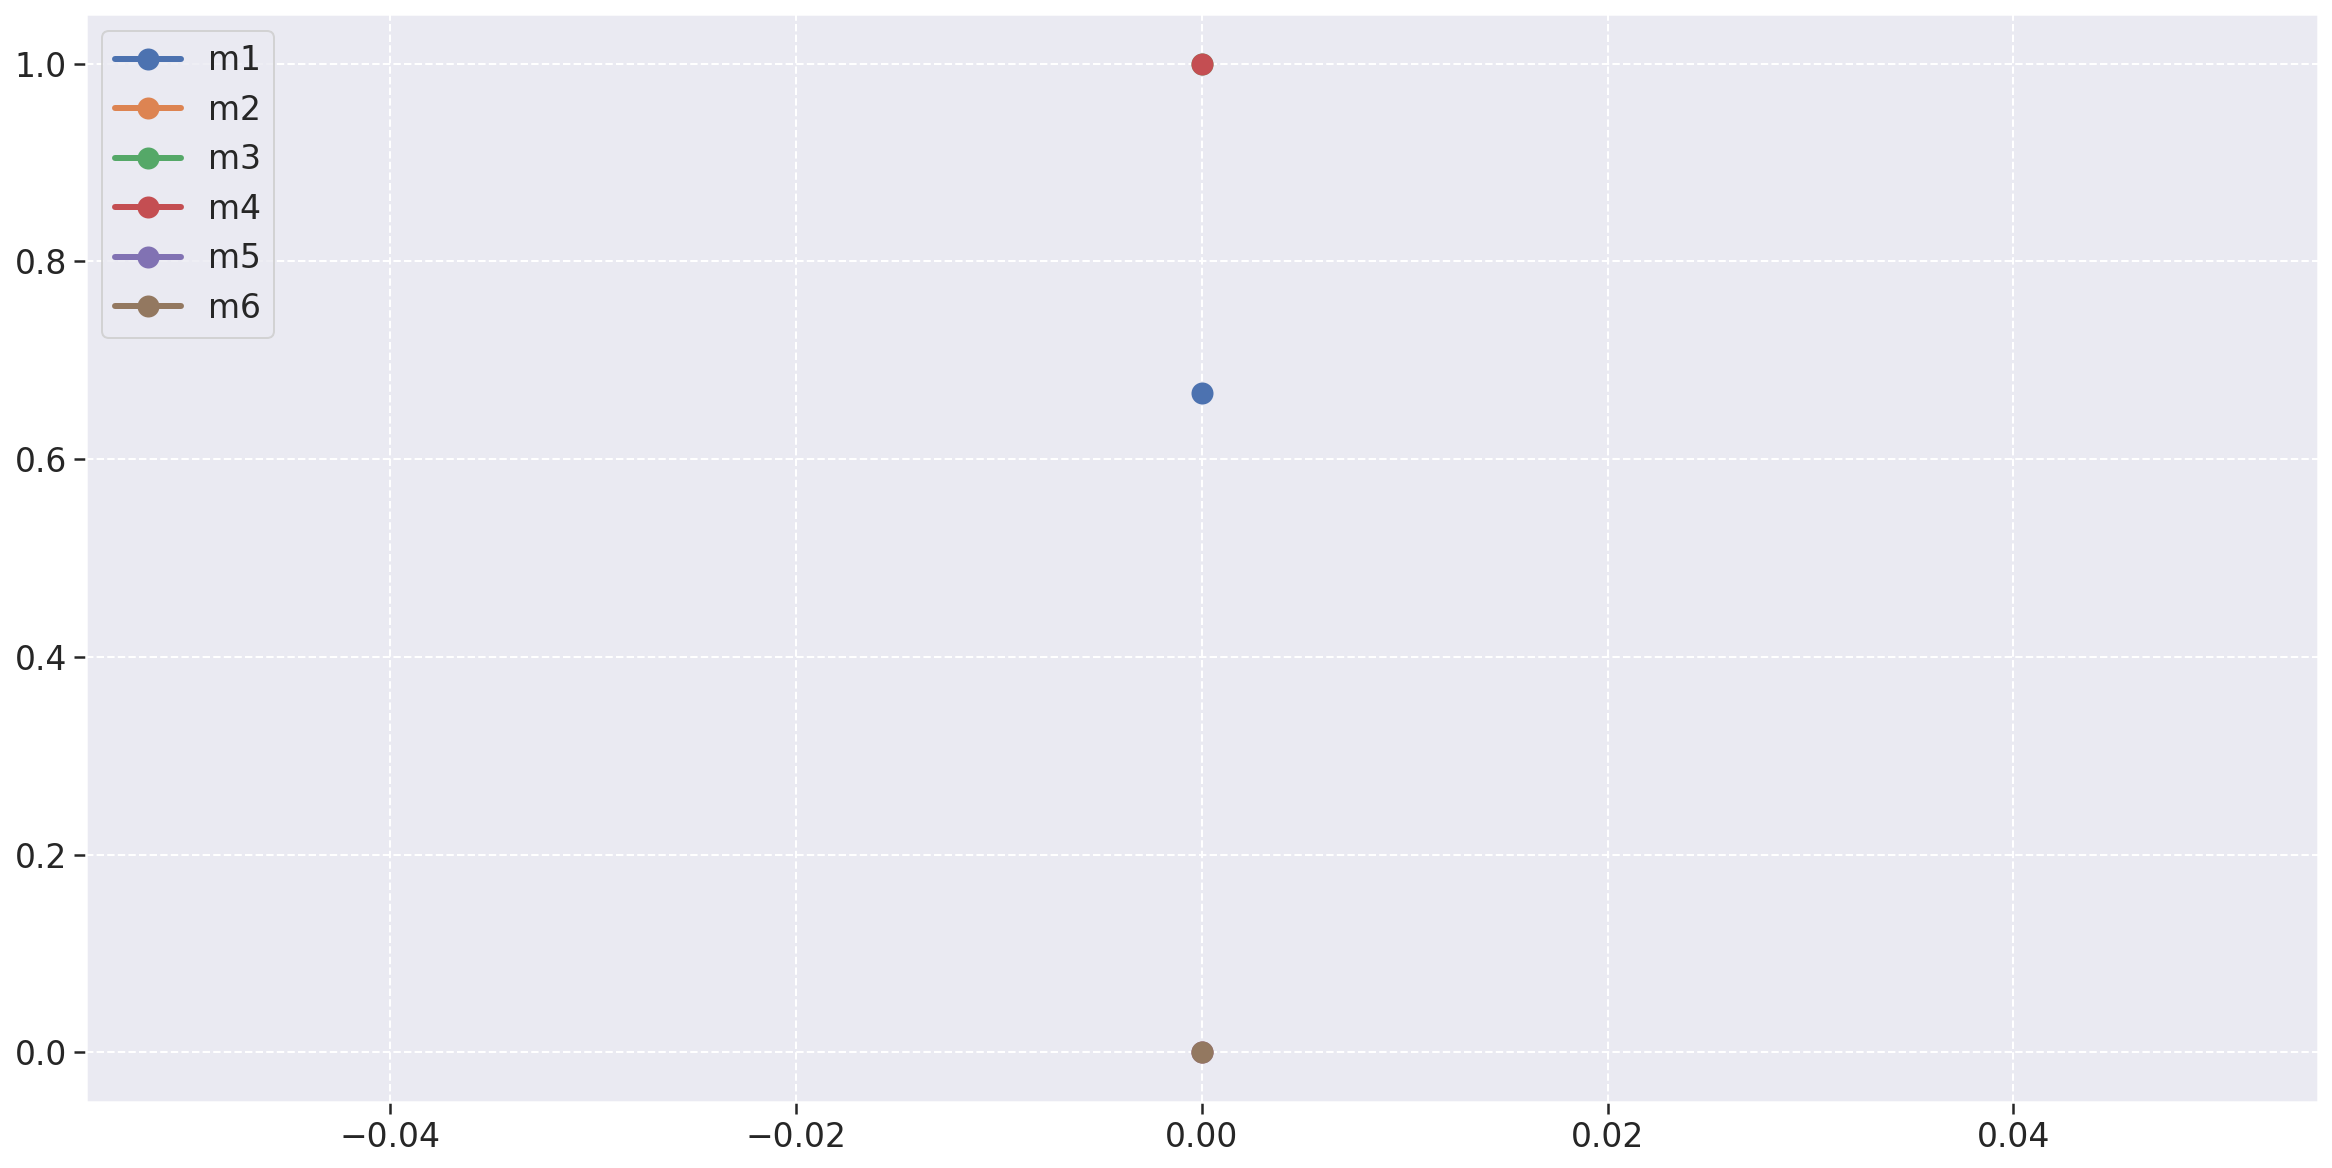

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.plot(tags_metrics['m1'], label='m1', linewidth=3, marker='o', markersize=10)
plt.plot(tags_metrics['m2'], label='m2', linewidth=3, marker='o', markersize=10)
plt.plot(tags_metrics['m3'], label='m3', linewidth=3, marker='o', markersize=10)
plt.plot(tags_metrics['m4'], label='m4', linewidth=3, marker='o', markersize=10)
plt.plot(tags_metrics['m5'], label='m5', linewidth=3, marker='o', markersize=10)
plt.plot(tags_metrics['m6'], label='m6', linewidth=3, marker='o', markersize=10)

plt.legend(loc='upper left')

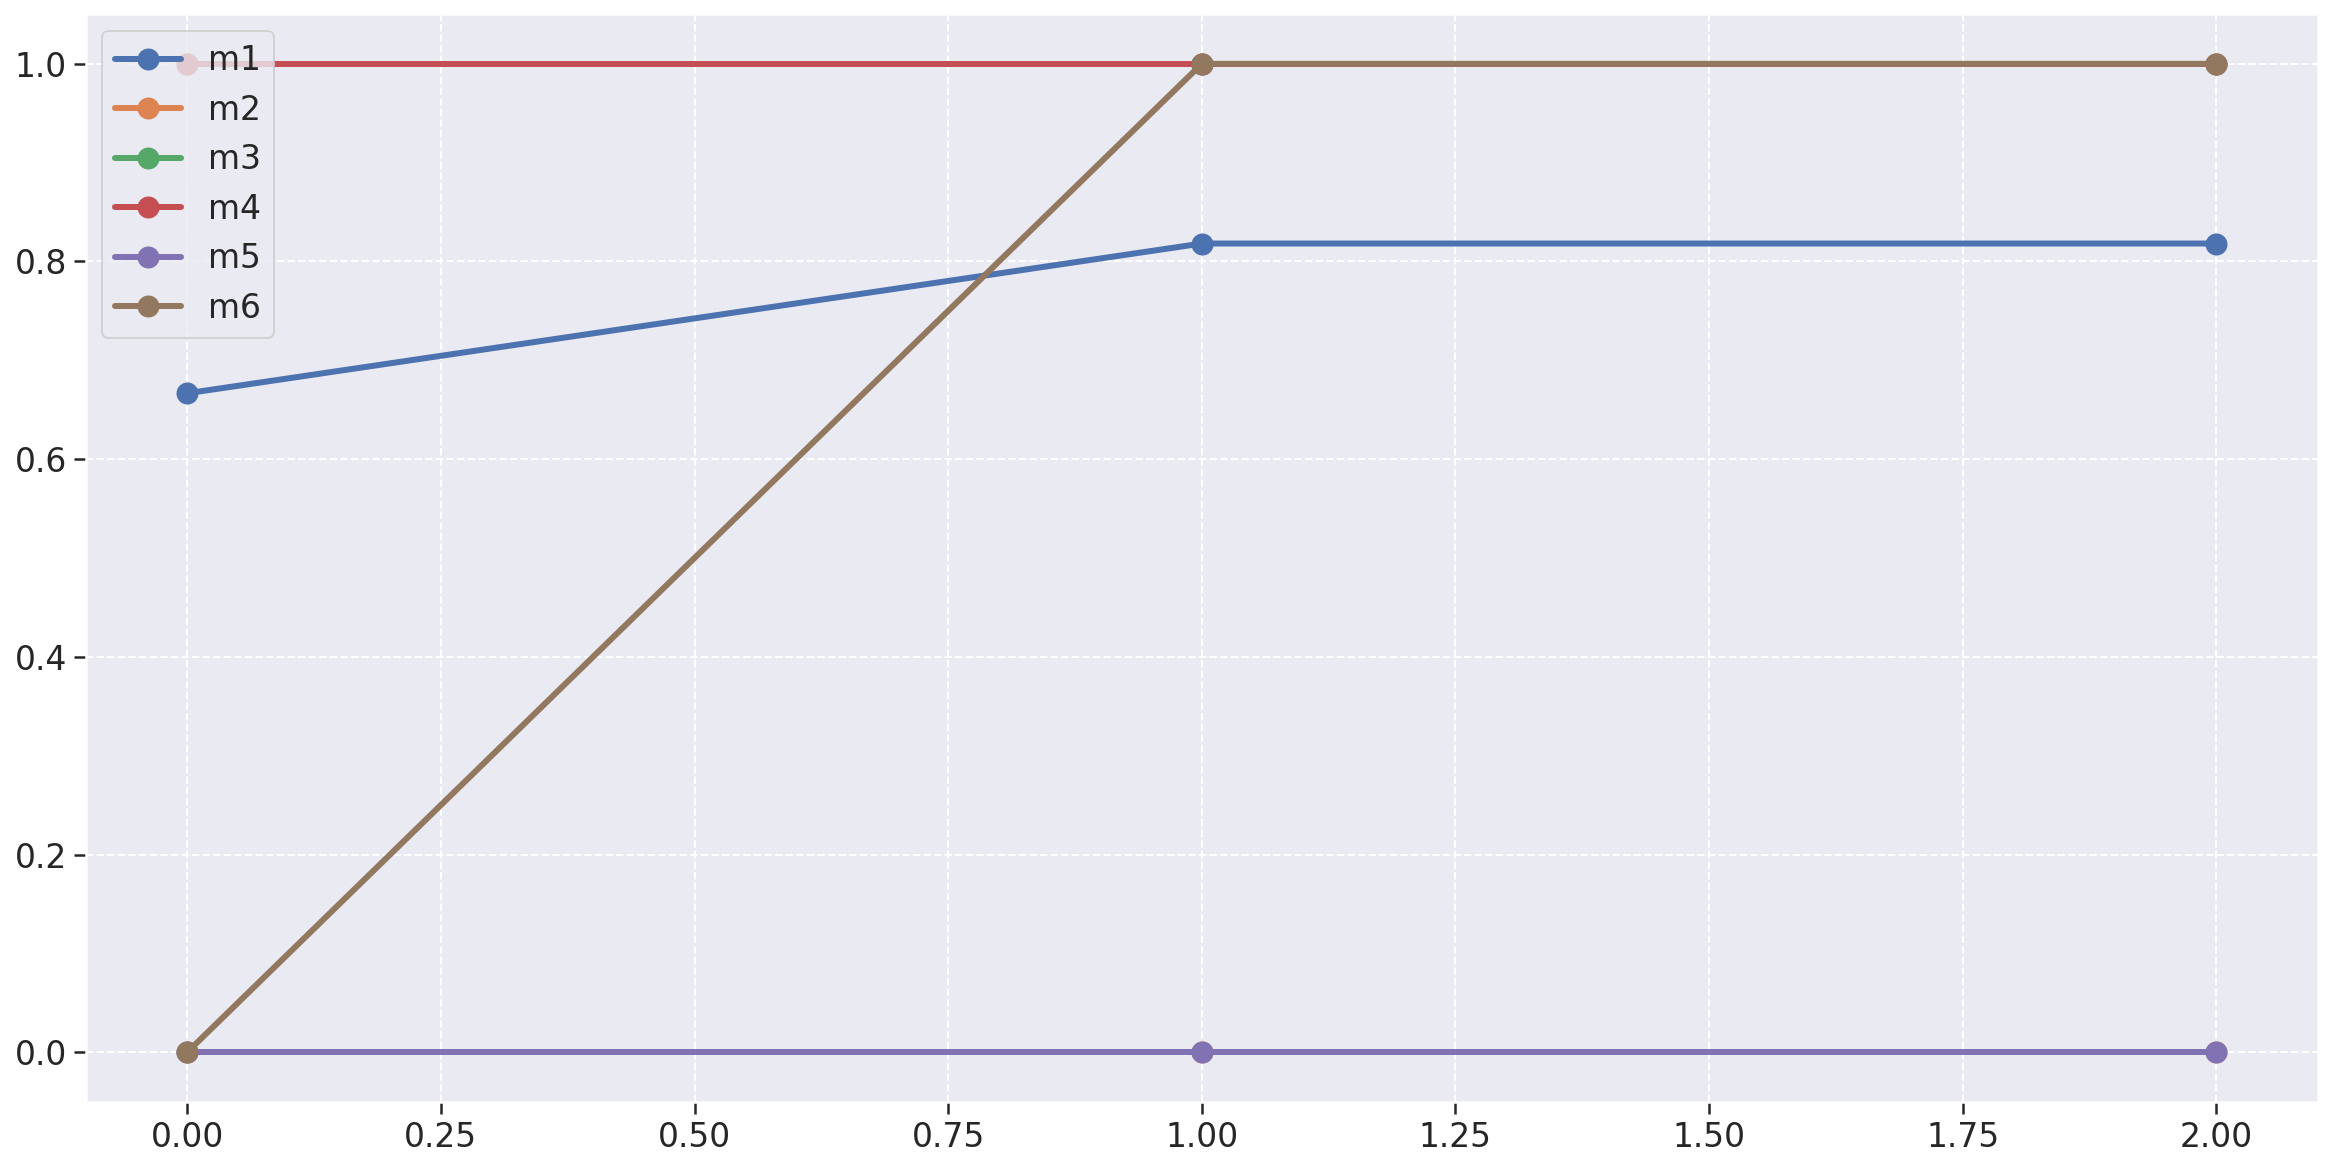

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.plot(profile_metrics['m1'], label='m1', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m2'], label='m2', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m3'], label='m3', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m4'], label='m4', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m5'], label='m5', linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m6'], label='m6', linewidth=3, marker='o', markersize=10)

plt.legend(loc='upper left')

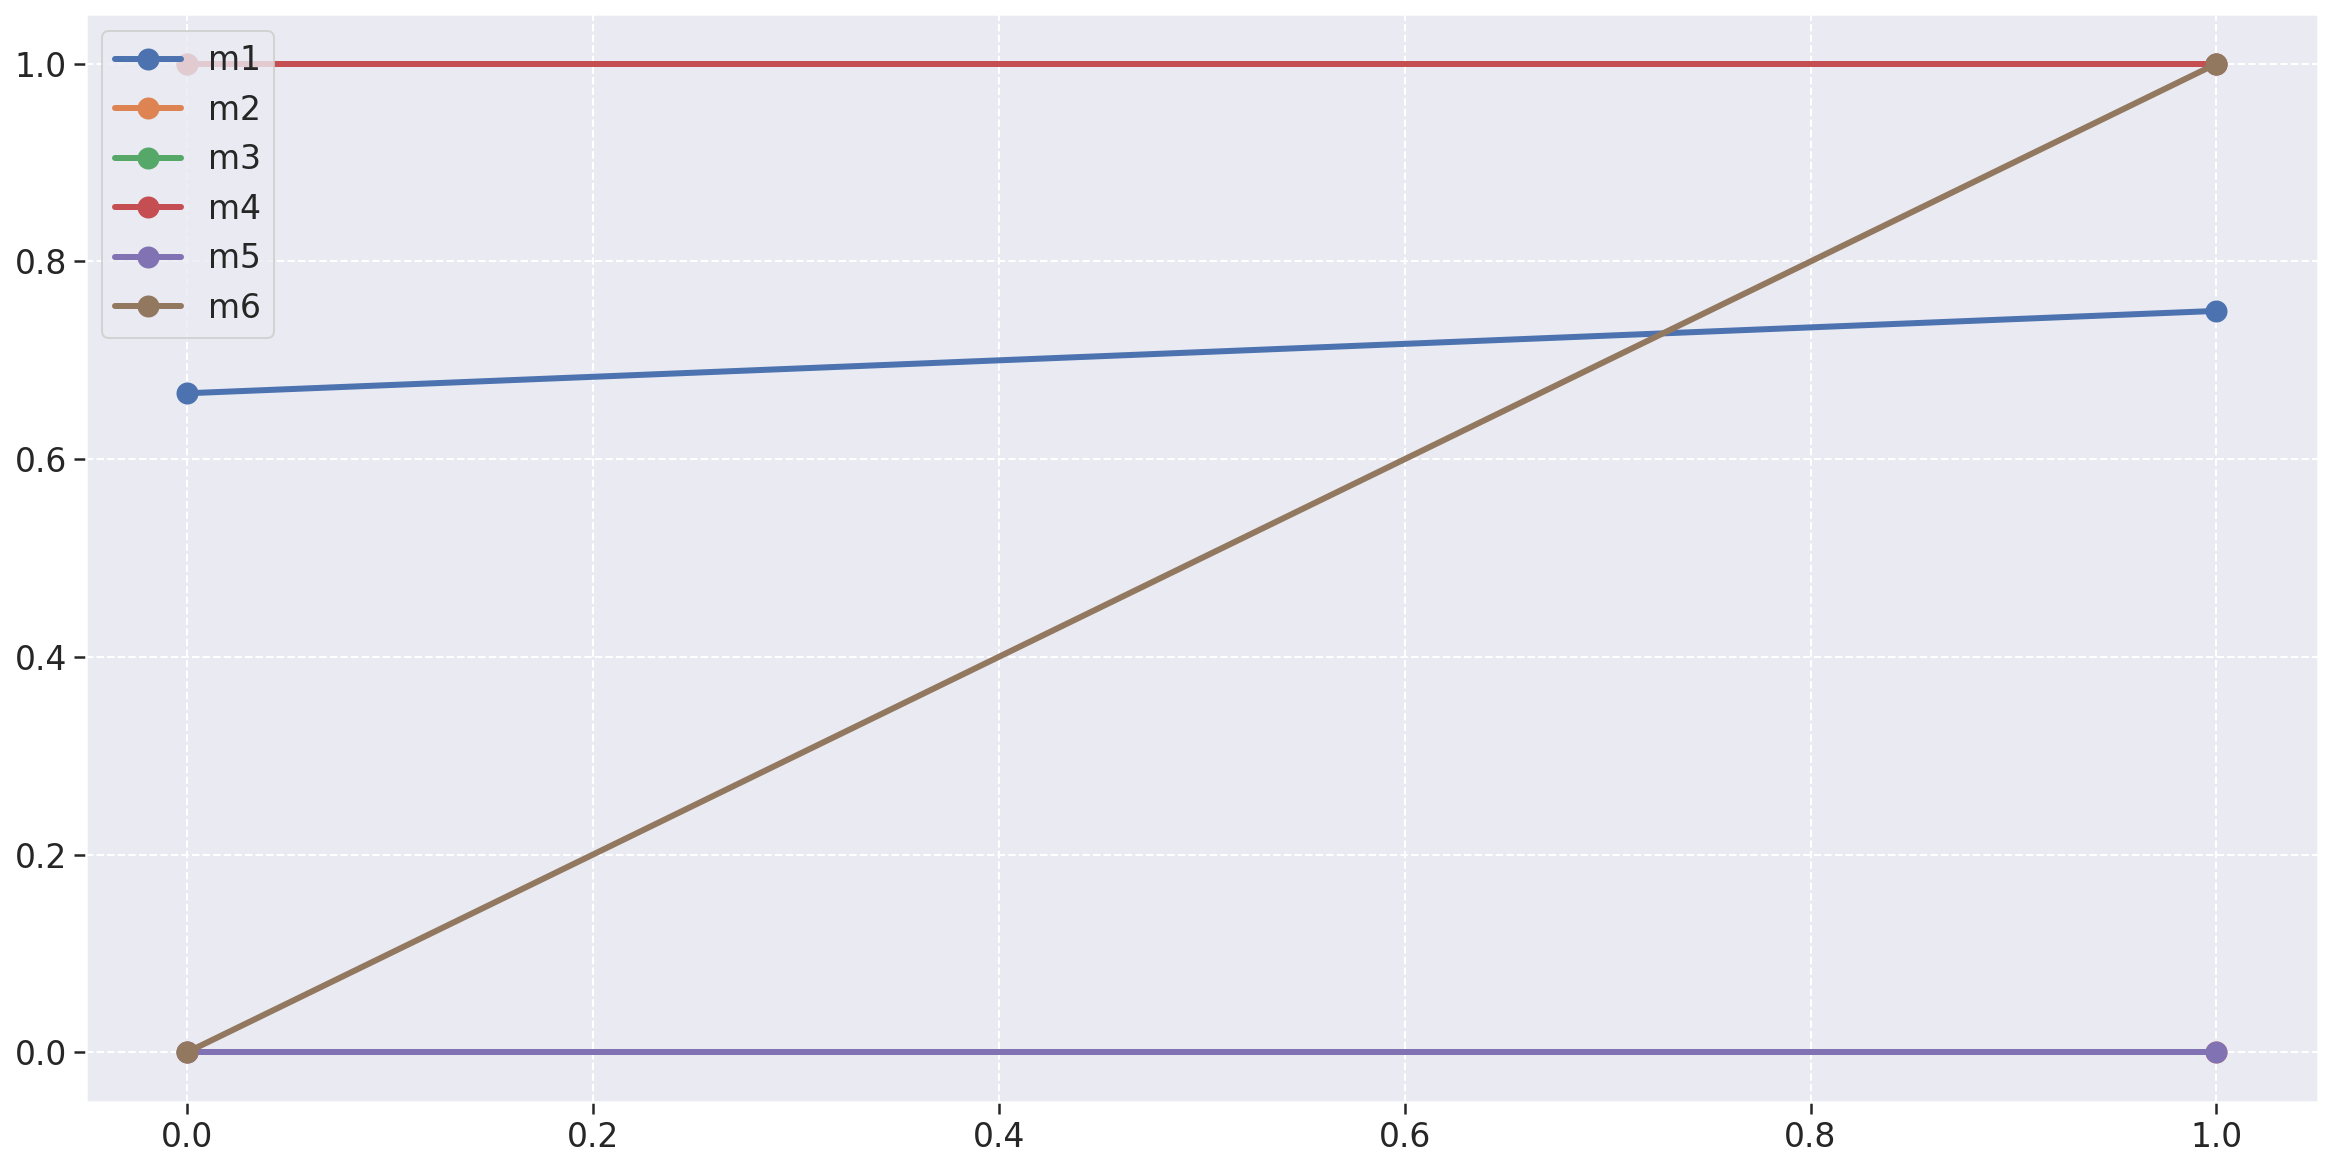

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.plot(processos_metrics['m1'], label='m1', linewidth=3, marker='o', markersize=10)
plt.plot(processos_metrics['m2'], label='m2', linewidth=3, marker='o', markersize=10)
plt.plot(processos_metrics['m3'], label='m3', linewidth=3, marker='o', markersize=10)
plt.plot(processos_metrics['m4'], label='m4', linewidth=3, marker='o', markersize=10)
plt.plot(processos_metrics['m5'], label='m5', linewidth=3, marker='o', markersize=10)
plt.plot(processos_metrics['m6'], label='m6', linewidth=3, marker='o', markersize=10)

plt.legend(loc='upper left')

### Sub characteristic aggregation

- You must do this for each of your repositories

In [26]:
psc1, psc2 = 1, 1
pc1, pc2 = 0.5, 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

frontEnd_metrics['code_quality'] = ((frontEnd_metrics['m1']*pm1) + (frontEnd_metrics['m2']*pm2) + (frontEnd_metrics['m3']*pm3)) * psc1
tags_metrics['code_quality'] = ((tags_metrics['m1']*pm1) + (tags_metrics['m2']*pm2) + (tags_metrics['m3']*pm3)) * psc1
profile_metrics['code_quality'] = ((profile_metrics['m1']*pm1) + (profile_metrics['m2']*pm2) + (profile_metrics['m3']*pm3)) * psc1
processos_metrics['code_quality'] = ((processos_metrics['m1']*pm1) + (processos_metrics['m2']*pm2) + (processos_metrics['m3']*pm3)) * psc1

frontEnd_metrics['testing_status'] = ((frontEnd_metrics['m4']*pm4) + (frontEnd_metrics['m5']*pm5) + (frontEnd_metrics['m6']*pm6)) * psc2
tags_metrics['testing_status'] = ((tags_metrics['m4']*pm4) + (tags_metrics['m5']*pm5) + (tags_metrics['m6']*pm6)) * psc2
profile_metrics['testing_status'] = ((profile_metrics['m4']*pm4) + (profile_metrics['m5']*pm5) + (profile_metrics['m6']*pm6)) * psc2
processos_metrics['testing_status'] = ((processos_metrics['m4']*pm4) + (processos_metrics['m5']*pm5) + (processos_metrics['m6']*pm6)) * psc2

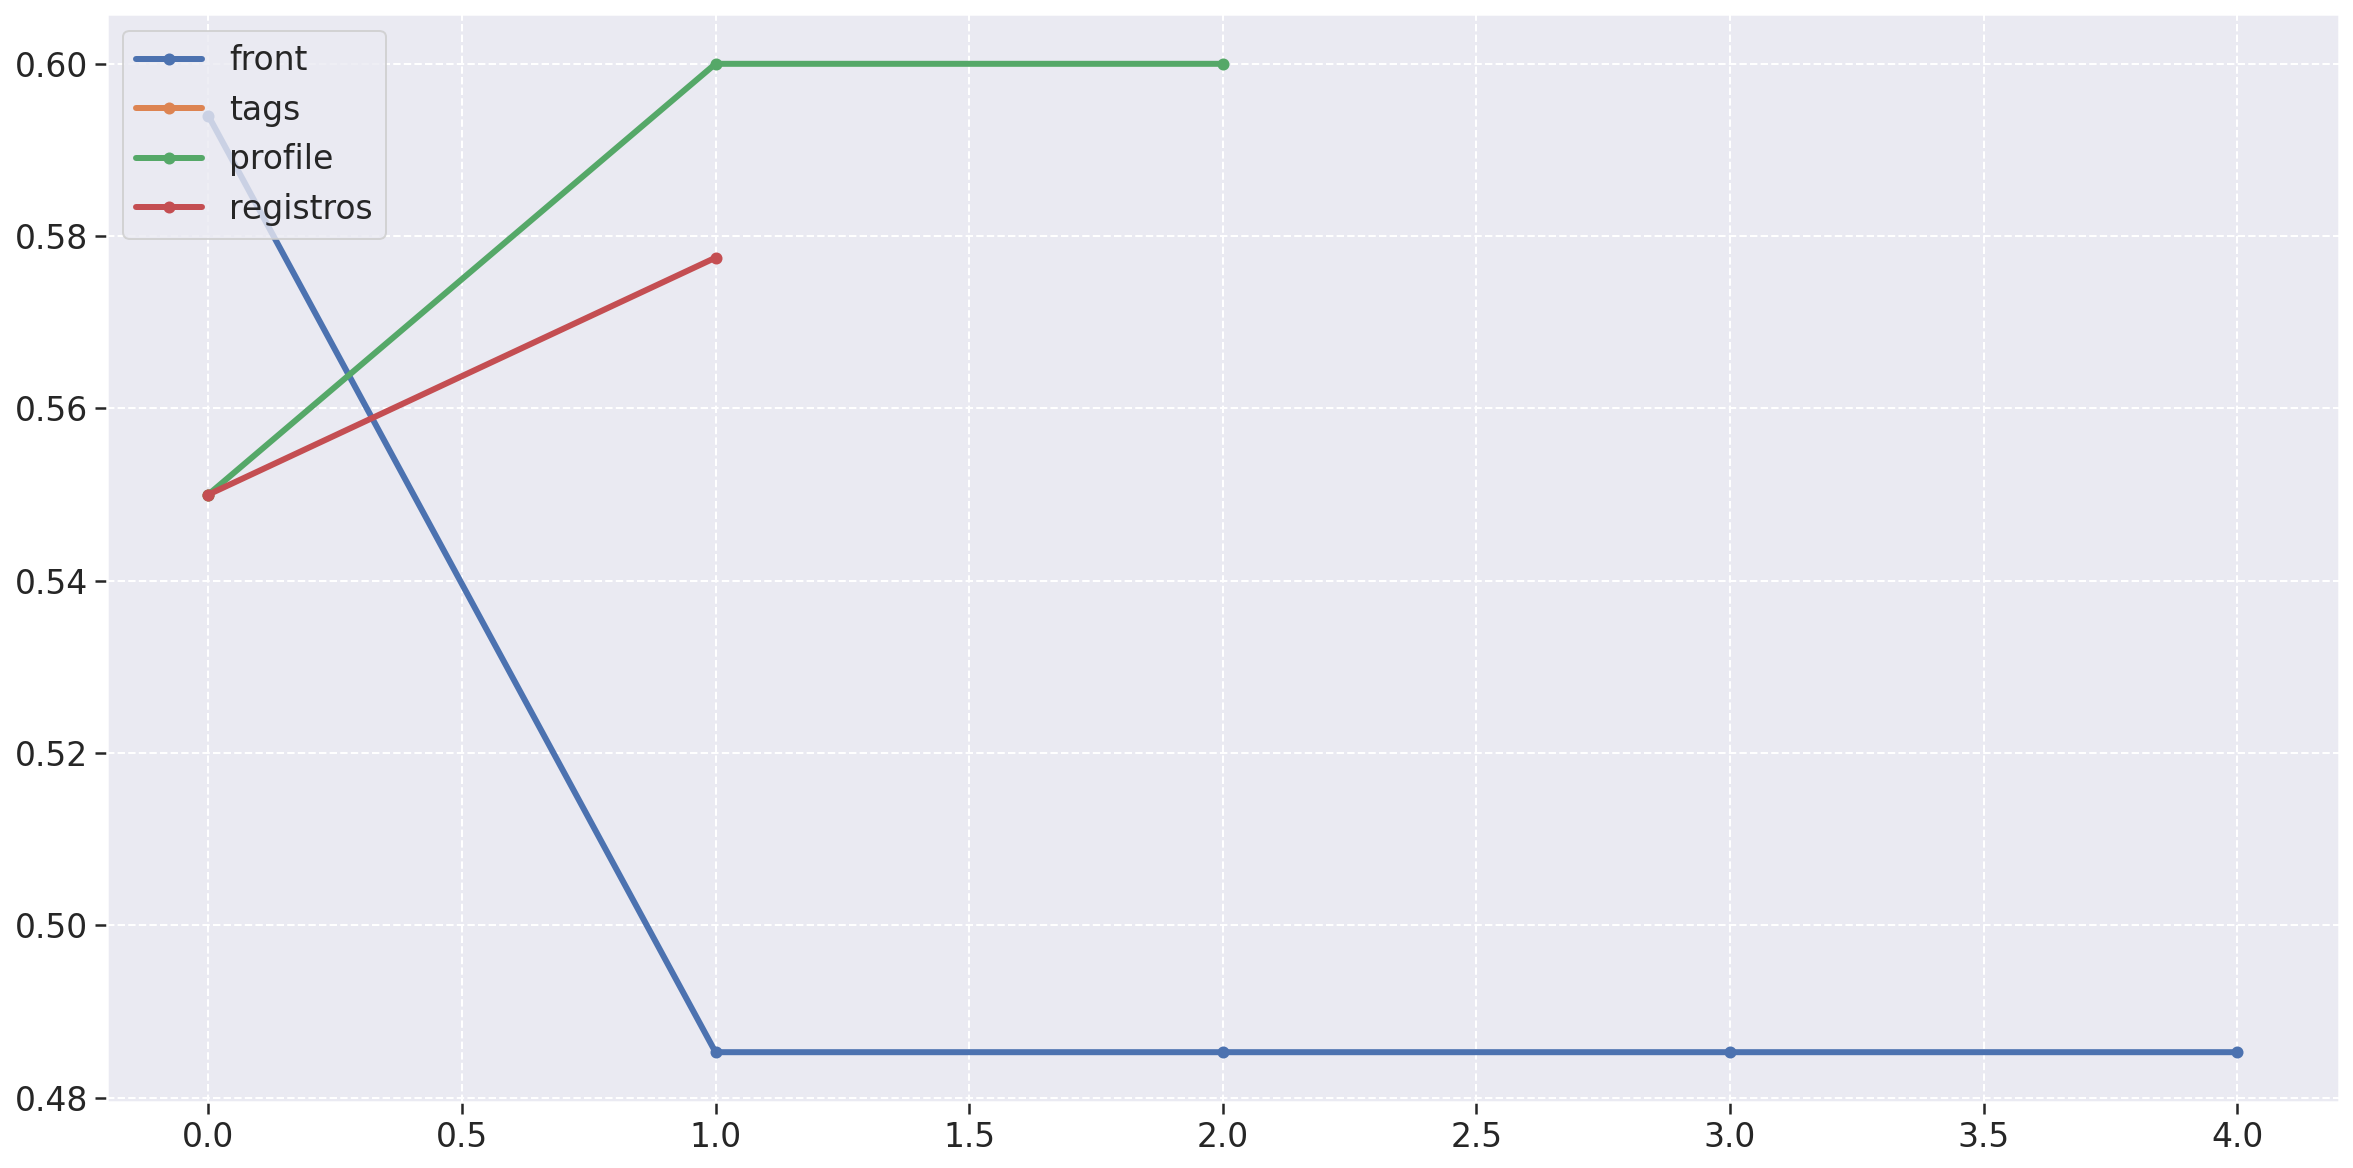

In [27]:
fig = plt.figure(figsize=(20, 10))


plt.plot(frontEnd_metrics['code_quality'], label='front', linewidth=3, marker='o', markersize=5)
plt.plot(tags_metrics['code_quality'], label='tags', linewidth=3, marker='o', markersize=5)
plt.plot(profile_metrics['code_quality'], label='profile', linewidth=3, marker='o', markersize=5)
plt.plot(processos_metrics['code_quality'], label='registros', linewidth=3, marker='o', markersize=5)

plt.legend(loc='upper left')

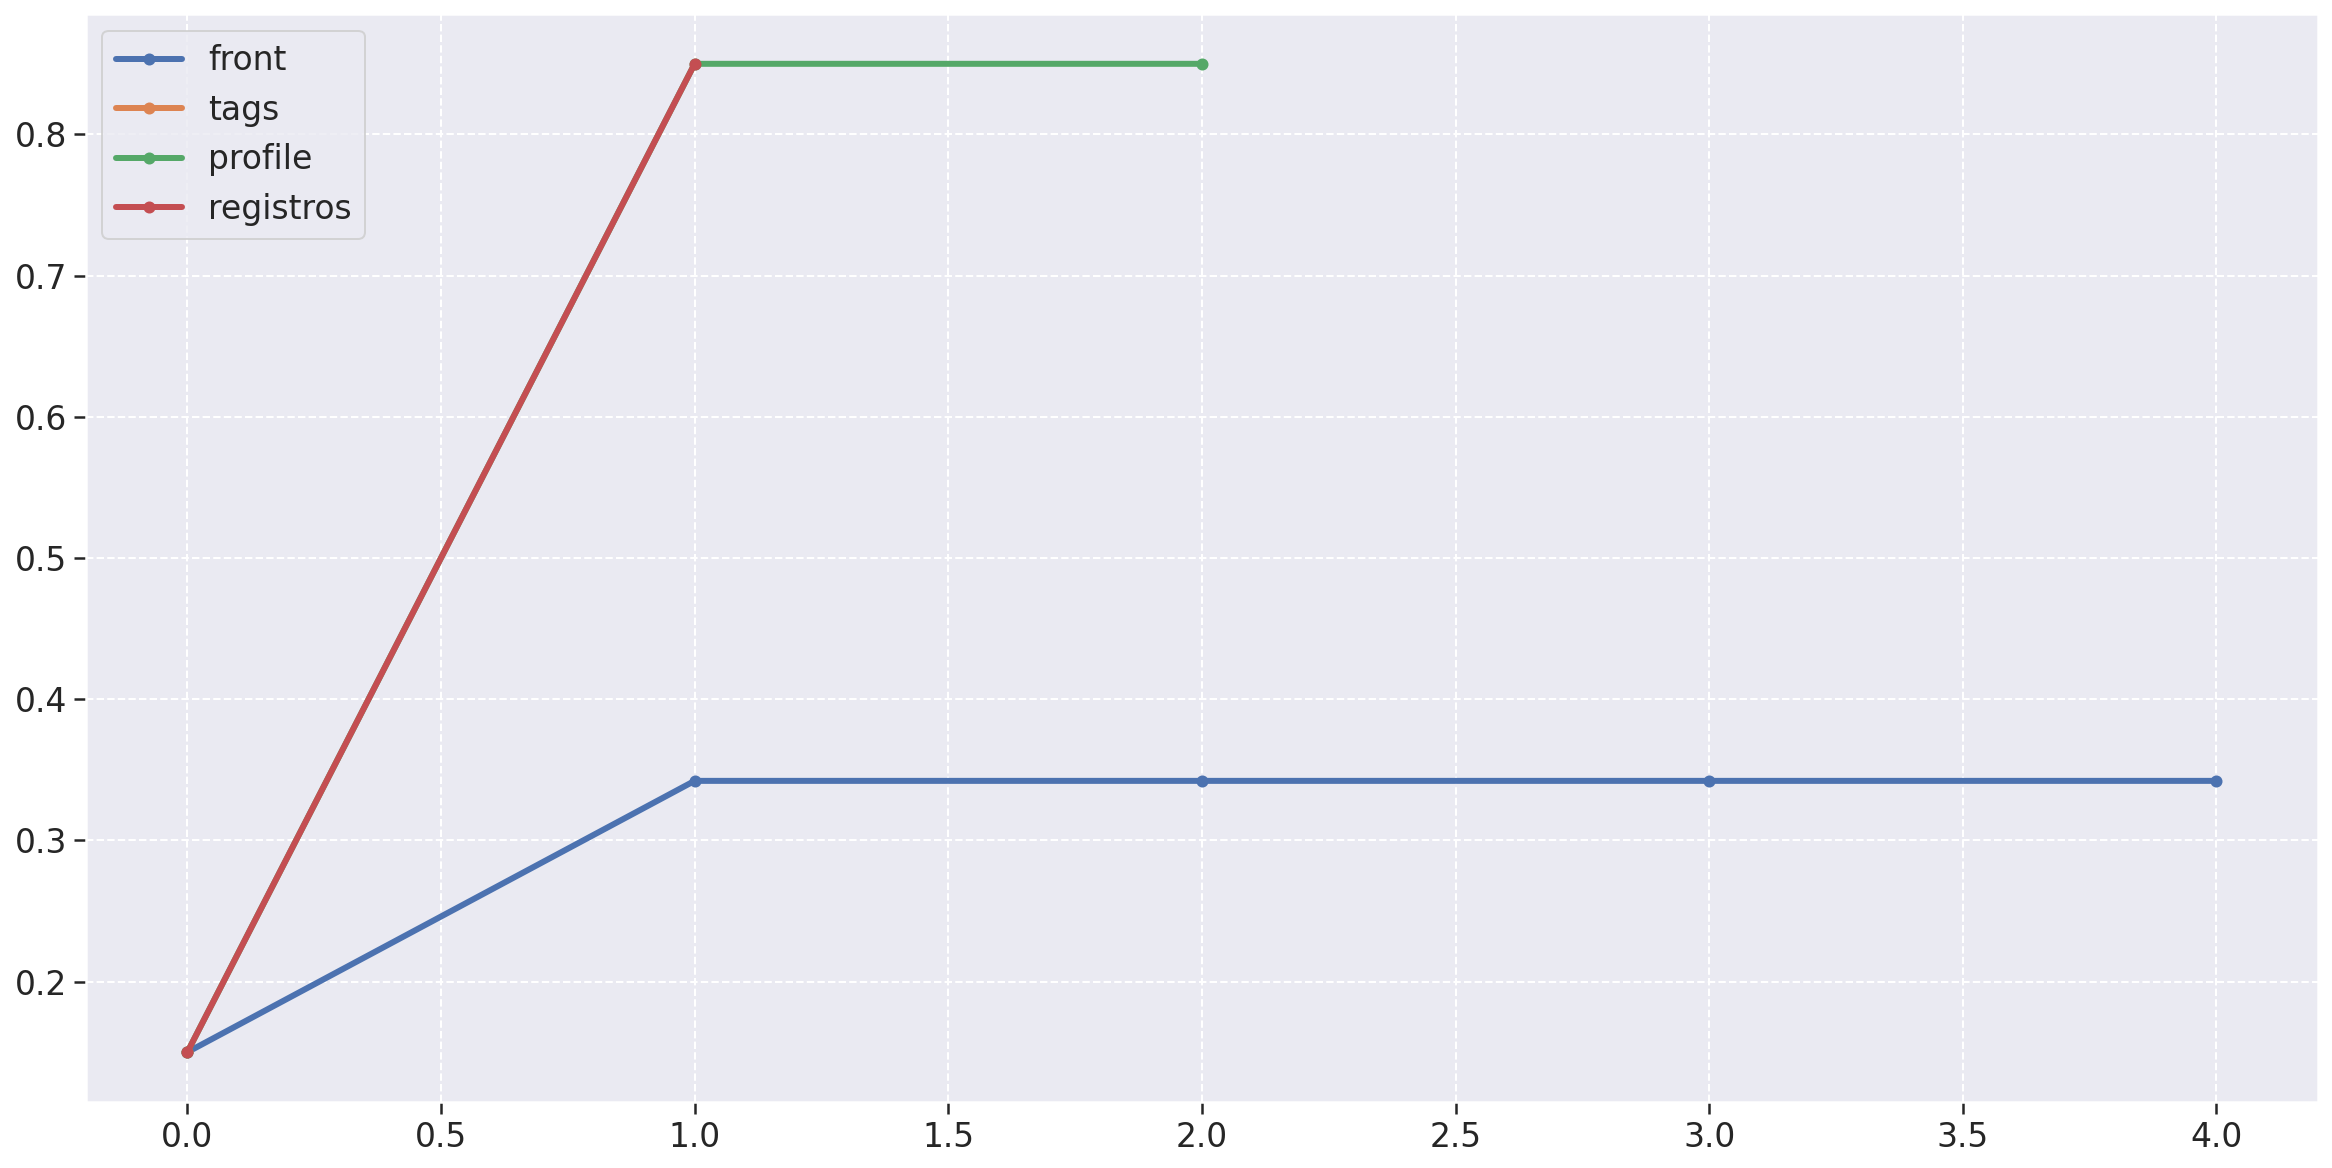

In [28]:
fig = plt.figure(figsize=(20, 10))


plt.plot(frontEnd_metrics['testing_status'], label='front', linewidth=3, marker='o', markersize=5)
plt.plot(tags_metrics['testing_status'], label='tags', linewidth=3, marker='o', markersize=5)
plt.plot(profile_metrics['testing_status'], label='profile', linewidth=3, marker='o', markersize=5)
plt.plot(processos_metrics['testing_status'], label='registros', linewidth=3, marker='o', markersize=5)

plt.legend(loc='upper left')

In [29]:
metrics_df = pd.concat([
frontEnd_metrics,
tags_metrics,
profile_metrics,
processos_metrics
], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [30]:
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,maintainability,Reliability,total
0,0.600000,0.200000,1.000000,1.0,0,0.00000,FrontEnd,09-14-2021-02-19,53,0.594000,0.150000,0.297000,0.075000,0.372000
1,0.490196,0.019608,0.960784,1.0,0,0.27451,FrontEnd,10-19-2021-02-02,2114,0.485294,0.342157,0.242647,0.171078,0.413725
2,0.490196,0.019608,0.960784,1.0,0,0.27451,FrontEnd,10-21-2021-03-24,2114,0.485294,0.342157,0.242647,0.171078,0.413725
3,0.490196,0.019608,0.960784,1.0,0,0.27451,FrontEnd,10-21-2021-04-17,2114,0.485294,0.342157,0.242647,0.171078,0.413725
4,0.490196,0.019608,0.960784,1.0,0,0.27451,FrontEnd,10-22-2021-01-58,2114,0.485294,0.342157,0.242647,0.171078,0.413725
5,0.666667,0.000000,1.000000,1.0,0,0.00000,Tags,09-14-2021-02-13,10,0.550000,0.150000,0.275000,0.075000,0.350000
6,0.666667,0.000000,1.000000,1.0,0,0.00000,Profile,09-14-2021-02-13,10,0.550000,0.150000,0.275000,0.075000,0.350000
7,0.818182,0.000000,1.000000,1.0,0,1.00000,Profile,10-20-2021-06-11,351,0.600000,0.850000,0.300000,0.425000,0.725000
8,0.818182,0.000000,1.000000,1.0,0,1.00000,Profile,10-20-2021-06-18,351,0.600000,0.850000,0.300000,0.425000,0.725000
9,0.666667,0.000000,1.000000,1.0,0,0.00000,Processos,09-14-2021-02-13,10,0.550000,0.150000,0.275000,0.075000,0.350000


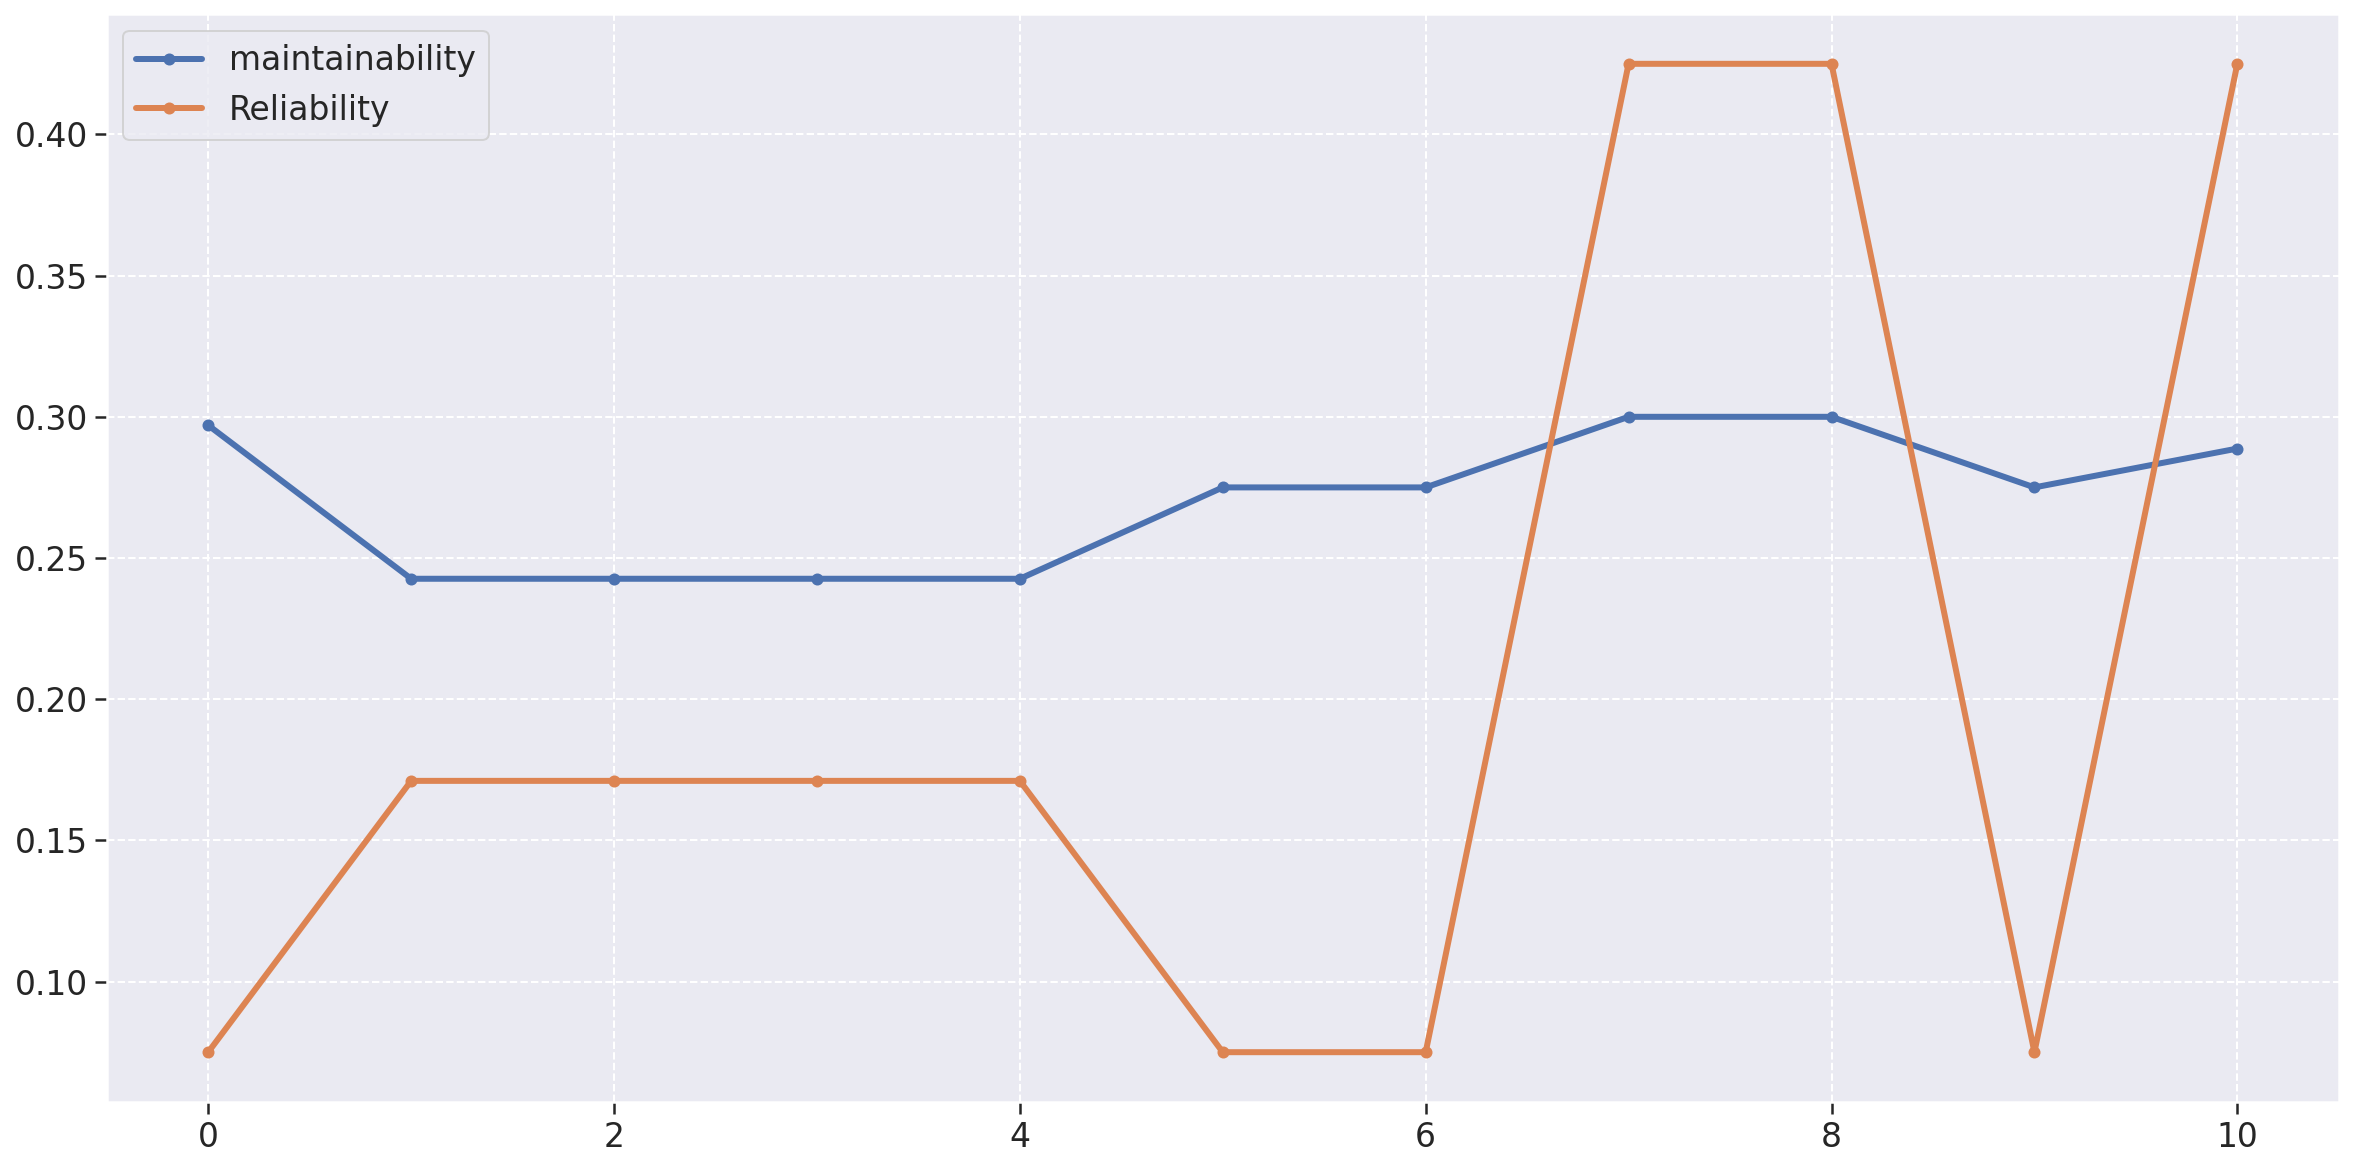

In [34]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], label='maintainability', linewidth=3, marker='o', markersize=5)
plt.plot(metrics_df['Reliability'], label='Reliability', linewidth=3, marker='o', markersize=5)

plt.legend(loc='upper left')

#plt.ylim(.45,.7)

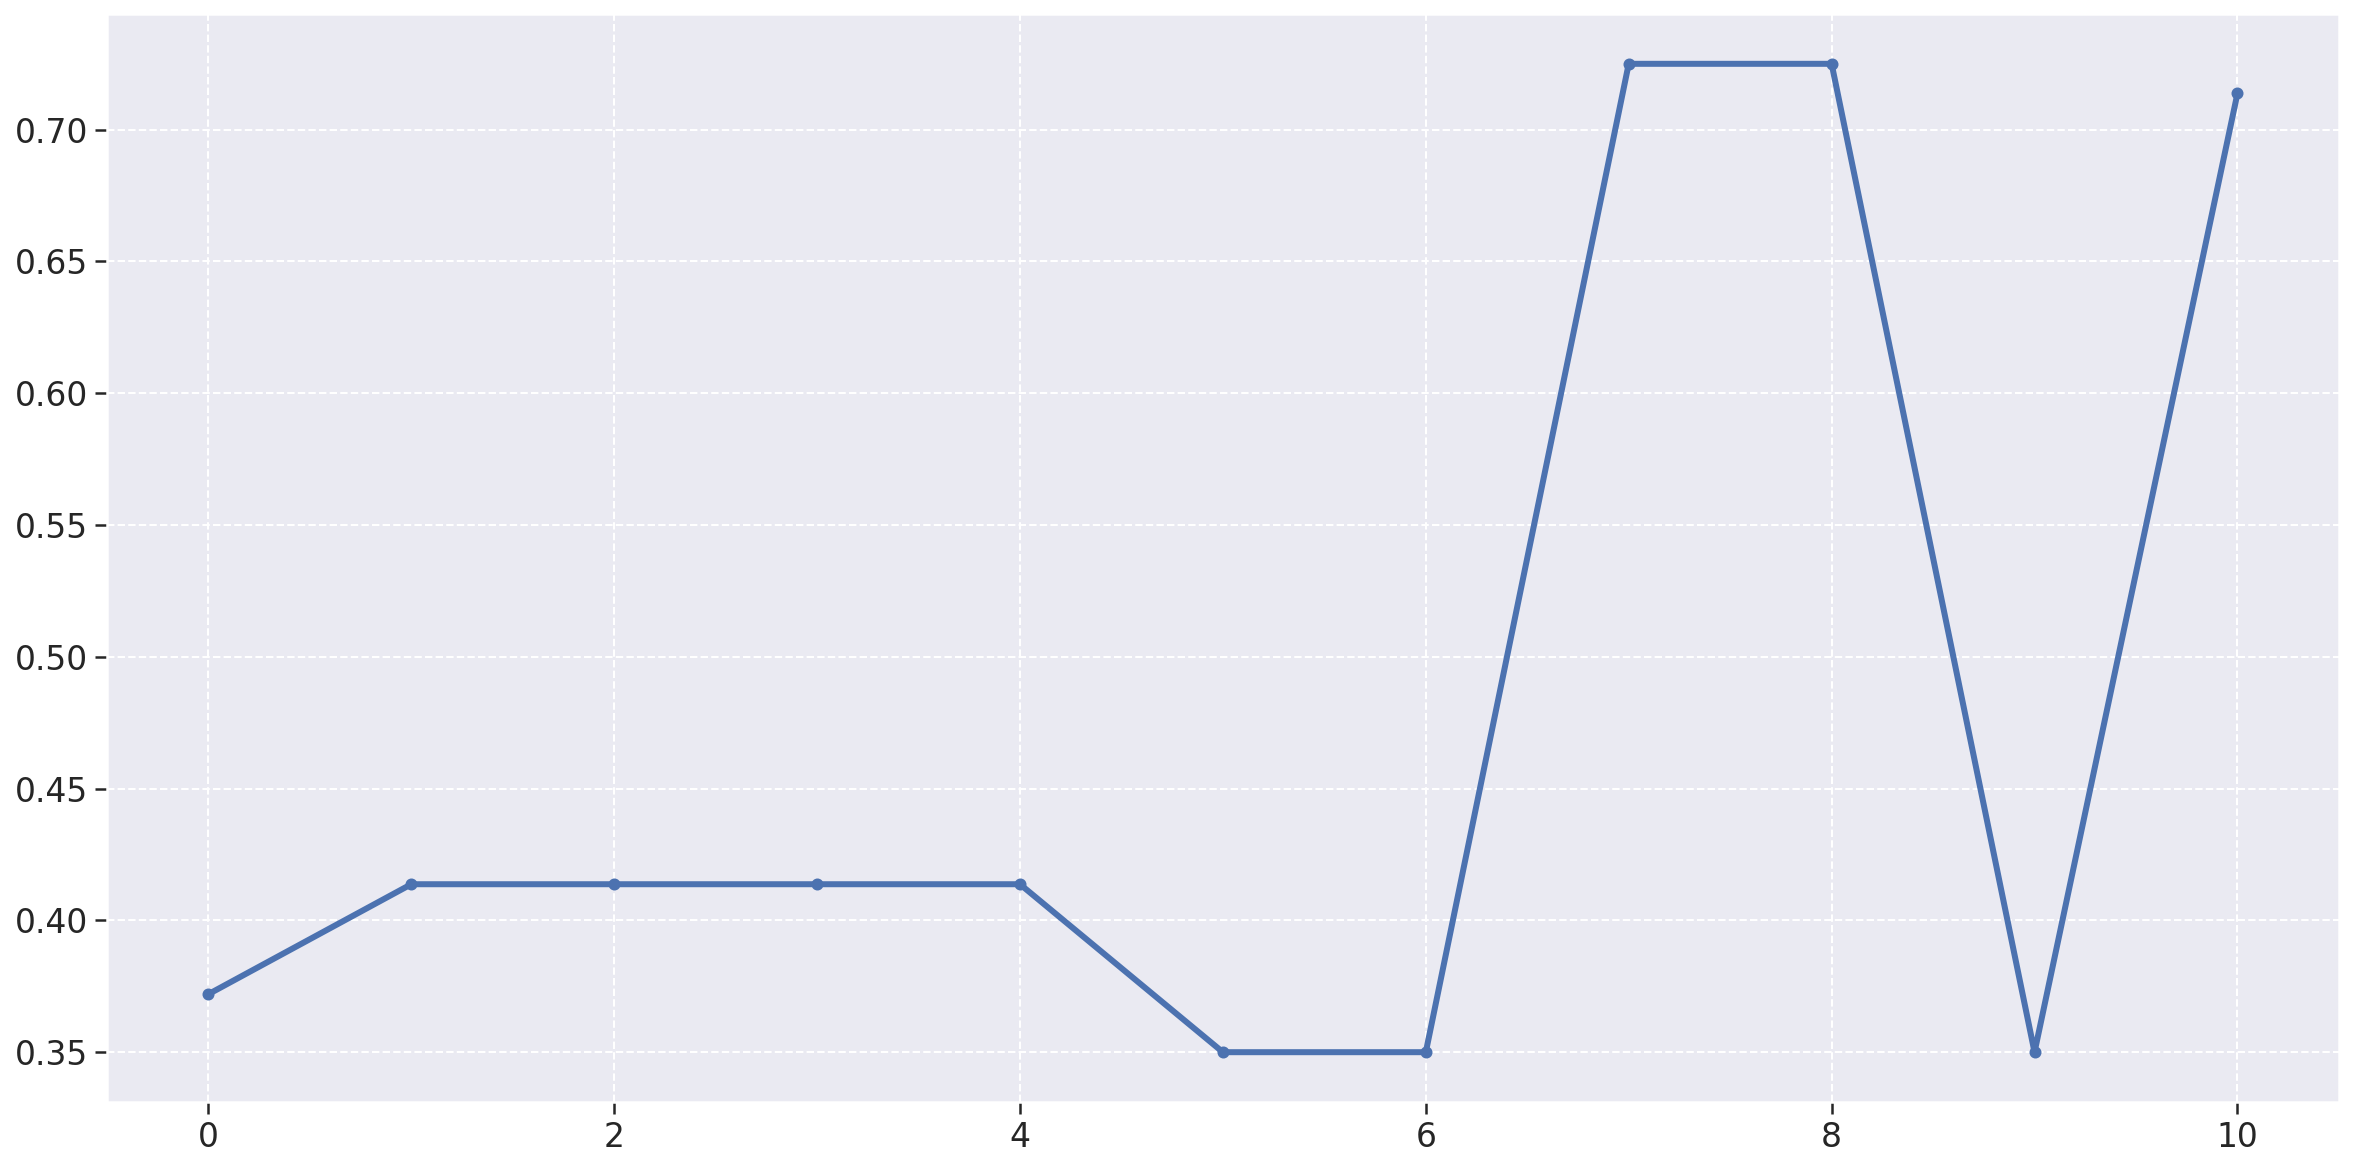

In [32]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)


#plt.ylim(.45,.7)


In [33]:
# ANALYSIS_DATE FORMAT: MM-DD-YYYY
from datetime import datetime

now = datetime.now()
now_str = now.strftime("%m-%d-%Y")

metrics_df.to_excel('data/fga-eps-mds-2021_1-Oraculo-DATASET-{}.xlsx'.format(now_str), index = False)
metrics_df.to_csv('data/fga-eps-mds-2021_1-Oraculo-DATASET-{}.csv'.format(now_str), index = False)